## Final Project Submission

Please fill out:
* Student name: Robert Fustero 
* Student pace: part time
* Scheduled project review 4/9/19
* Instructor name: Brandon Lewis



## OSEMN Process

## Obtain: 
* First import the database and neccesary libararies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
import statistics
#plt.style.use('seaborn')
df = pd.read_csv('kc_house_data.csv')
from statistics import mean
from matplotlib import style
import warnings
warnings.filterwarnings('ignore')
linreg = LinearRegression()
ridge = Ridge()
plt.style.use('fivethirtyeight')





In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Scrub/ Explore
This step involves looking through your data and asking questions
* What factors are the best predictors for price?
* What are the most important thing(s) to consider when flipping a house?

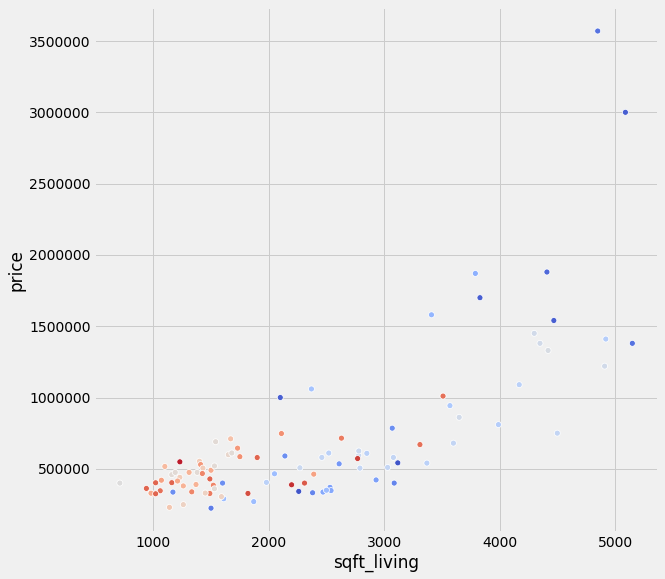

In [4]:
plt.figure(figsize=(9,9))
cmap = palette=sns.color_palette('coolwarm', n_colors=43)
sns.scatterplot(x='sqft_living',y='price', hue='zipcode', palette=cmap,data=df.tail(100), legend=False)

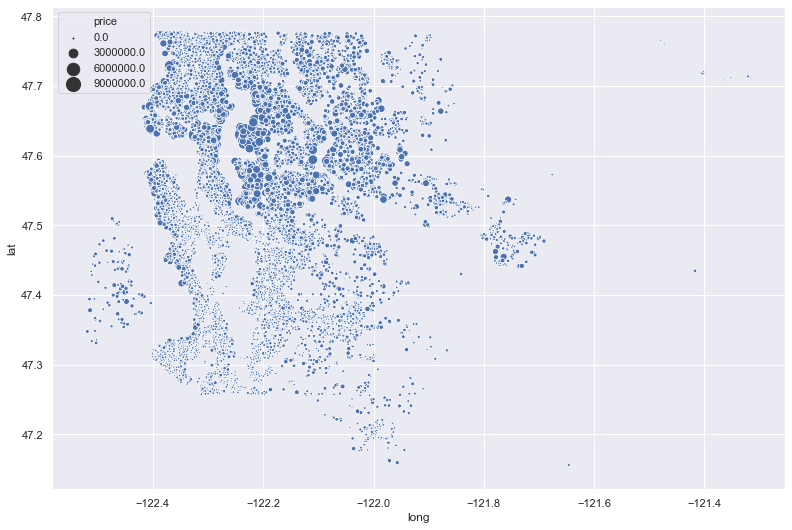

In [5]:
cmap = sns.cubehelix_palette(dark=0, light=.1, as_cmap=True, reverse=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x='long',y='lat', size='price',sizes=(1, 200), palette=cmap,data=df)

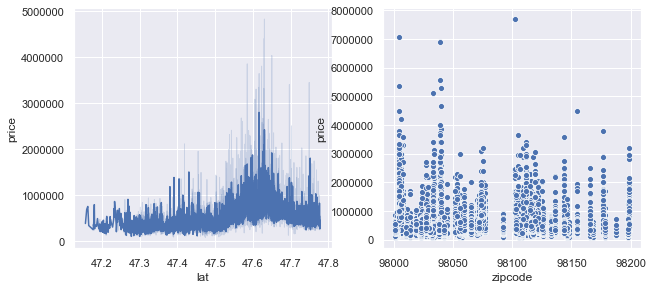

In [6]:
plt.figure(figsize=(14,14))
plt.subplot(331)
sns.lineplot(x='lat',y='price',data=df)
plt.subplot(332)
sns.scatterplot(x ='zipcode', y='price',data=df)

So clearly location and the size of the house are the most important factors for predicting the price.  Some spots on the map bulge out at you and some spots shrink.  Another thing you can notice by the lat vs price graph is - there are certain climate zones that bring in higher prices than others.  I decided to factor this into my final model by building a ranking system for the zipcodes and climate.

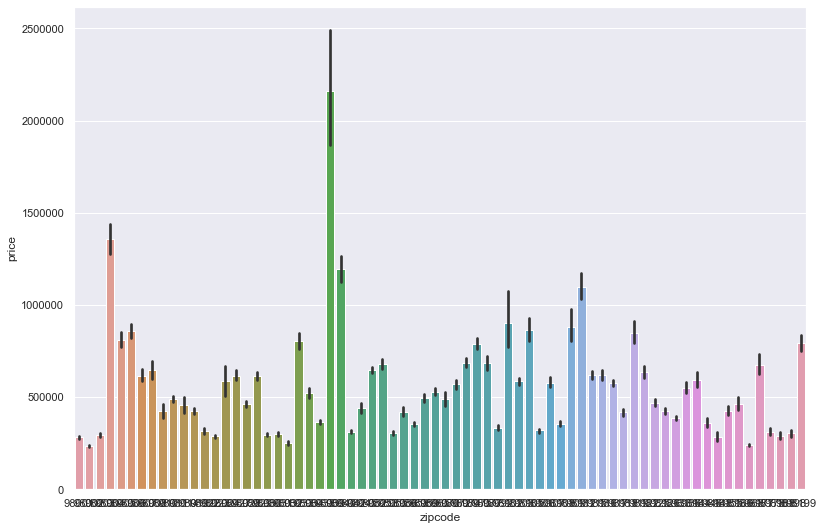

In [7]:

sns.barplot(x='zipcode',y='price',data=df,saturation=0.6, errcolor='.2' )

Where you live influences the price of your home.  I decided to program a zipcode ranking system based on the median.  I ranked 6 differet home prices based on increments on the minimun average price.

In [8]:
low = statistics.median(df.groupby('zipcode').price.mean().tolist()) - min(df.groupby('zipcode').price.mean().tolist())
lmid = statistics.median(df.groupby('zipcode').price.mean().tolist())
hmid = statistics.median(df.groupby('zipcode').price.mean().tolist()) + min(df.groupby('zipcode').price.mean().tolist())
high = statistics.median(df.groupby('zipcode').price.mean().tolist()) + 2*min(df.groupby('zipcode').price.mean().tolist())+120000
hhigh = statistics.median(df.groupby('zipcode').price.mean().tolist()) + 3*min(df.groupby('zipcode').price.mean().tolist())
print("Lowest:",round(low),"Middle:",round(hmid),"Highest:",round(hhigh))

Lowest: 257717 Middle: 726285 Highest: 1194853


In [9]:
def zipranker(data):
    ndict = {}
    ziplist = []
    for code in data.zipcode.tolist():
        if df.groupby(data.zipcode==code).price.mean().tolist()[1] < low:
            ndict.update({code:1})
        elif df.groupby(data.zipcode==code).price.mean().tolist()[1] < lmid:
            ndict.update({code:2})
        elif df.groupby(data.zipcode==code).price.mean().tolist()[1] < hmid:
            ndict.update({code:3})
        elif df.groupby(data.zipcode==code).price.mean().tolist()[1] < high:
            ndict.update({code:4})
        elif df.groupby(data.zipcode==code).price.mean().tolist()[1] < hhigh:
            ndict.update({code:5})
        else:
            ndict.update({code:6})
    for zc in data.zipcode.tolist():
        ziplist.append(ndict[zc])
    data['nrank']= pd.Series(ziplist)

        
    return data
df = zipranker(df)

In [10]:

def climranker(data):
    cdict = {}
    climlist = []
    for lat in data.lat.tolist():
        if lat < 47.3:
            cdict.update({lat:1})
        elif lat < 47.4:
            cdict.update({lat:2})
        elif lat < 47.45:
            cdict.update({lat:3})
        elif lat < 47.5:
            cdict.update({lat:4})
        elif lat < 47.6:
            cdict.update({lat:5})
        elif lat < 47.7:
            cdict.update({lat:6})
        else:
            cdict.update({lat:7})
    for c in data.lat.tolist():
        climlist.append(cdict[c])
    data['crank']= pd.Series(climlist)
    

        
    return data
df = climranker(df)
climrankdict={}
crlist=[]
for c in df.crank.tolist():
    climrankdict.update({c:crlist.append(df.groupby(df.crank==c).price.mean()[1])})
for c in df.crank.tolist():
    crlist.append(climrankdict[c])

df['climrank']= pd.Series(crlist)
df = df.drop(['crank'],axis=1)

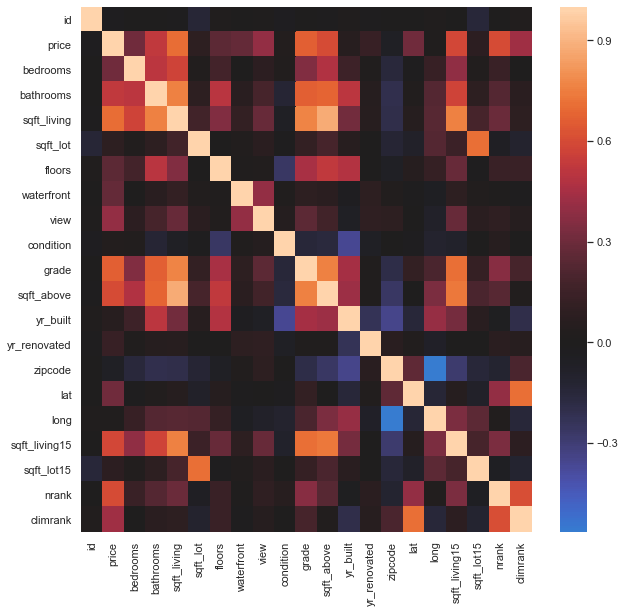

In [11]:
plt.figure(figsize=(9,9))
sns.heatmap(df.corr(), center=0, );

Great! I found a way to take quantify location and turn it into a ranking variable that's correlated with price

Next, lets look at the homes sold twice and see if we can learn anything from the houses that made a profit

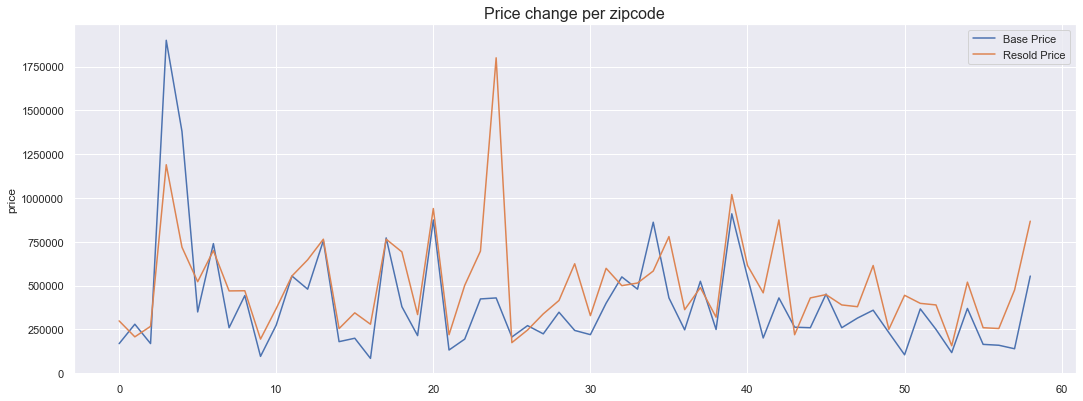

In [14]:
dup = df[ df.id.duplicated(keep=False) ]

zipprice = dup.groupby('zipcode')['price']
plt.figure(figsize=(16,6))

sns.lineplot( range(len(zipprice)), zipprice.first(), label='Base Price' )
sns.lineplot( range(len(zipprice)), zipprice.last(), label='Resold Price' )
plt.title('Price change per zipcode', fontdict={'fontsize': 16})
plt.legend()
plt.show()


Let's see if we can take the information we have learn from what worked and what didnt work when people tried to flip houses

That's interesting - it looks like some homesellers actually lost money.  Let's see who made the most and who lost the most and examine their data

In [15]:
def identicalremover(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]
def keywithmaxval(d):
    v=list(d.values())
    k=list(d.keys())
    return k[v.index(max(v))]
def keywithminval(d):
    v=list(d.values())
    k=list(d.keys())
    return k[v.index(min(v))]


firstprice=[]
secondprice=[]
profdict={}


for z in dup.zipcode:
    pricelist=[]
    tuplist=[]
    idlist=[]
    firstsale=[]
    secondsale=[]
    profitlist=[]
    for row in dup[dup.zipcode==z].iterrows():
        pricelist.append(row[1][2])
    

    for row in dup[dup.zipcode==z].iterrows():
        idlist.append(row[1][0])
        
    firstsale=[]
    secondsale=[]
    profitlist=[]

    for sale in range(len(pricelist)):

        if sale%2==0:
            firstsale.append(pricelist[sale])
        else:
            secondsale.append(pricelist[sale])
    for i in range(len(secondsale)):
        profit=secondsale[i]-firstsale[i]
        profitlist.append(profit)

    idlist= identicalremover(idlist)

    for j in range(len(idlist)):
        profdict[idlist[j]]=profitlist[j]
print("Max profit:",max(list(profdict.values())),"Biggest loss:",min(list(profdict.values())),"Average sale:",round(np.mean(list(profdict.values()))))
print("Highest profit:",keywithmaxval(profdict), "Biggest loss:",keywithminval(profdict))


Max profit: 529950.0 Biggest loss: -40000.0 Average sale: 136380.0
Highest profit: 6021500970 Biggest loss: 7167000040


Let's see what the guy who made the most did right

In [16]:
df[df.id==6021500970][['price','grade','condition','sqft_living','floors','date']]

,price,grade,condition,sqft_living,floors,date
19320,345000.0,7,3,1080,1.0,5/28/2014
19321,874950.0,7,3,1080,1.0,4/7/2015


The grade and condition didnt change.  Neither did the living space and floor.  Let's look at the neighborhood around this house.

In [17]:
df[df.zipcode==98117].price.mean()

576834.808318264

In this one scenario, a modest sized house was flipped for a nice profit because it was in a nice neighborhood with an average home value of $576834

In [18]:
df[df.id==7167000040][['price','grade','condition','sqft_living','floors','date']]

,price,grade,condition,sqft_living,floors,date
13285,740000.0,10,3,3350,2.0,8/13/2014
13286,700000.0,10,3,3350,2.0,3/5/2015


Same story, no difference so let's examine the neighborhood

In [19]:
df[df.zipcode==98010].price.mean()

423665.99

In this other scenario, the home seller ended up losing money off of a big home in a neighborhood that isnt as favorable with an average price of $423665 

Let's take a look at some simple linear regressions models so we can get a better understanding of the what factors best indictate price.

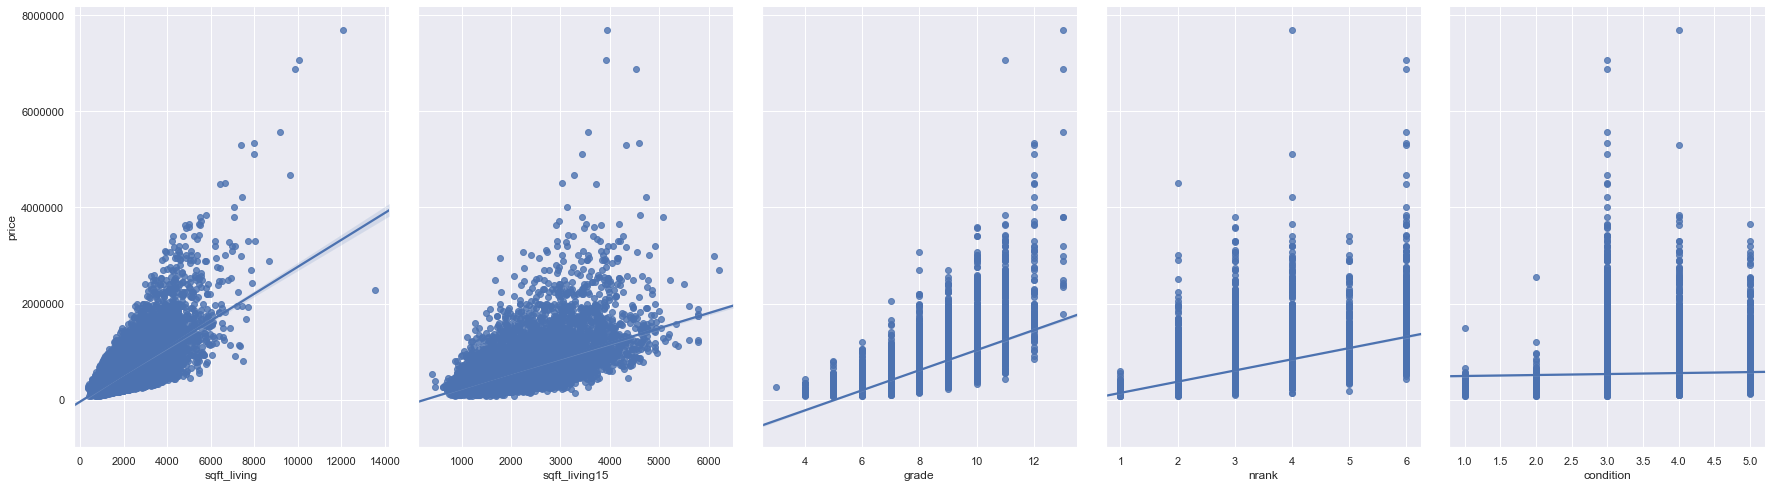

In [20]:

sns.pairplot(df, x_vars=['sqft_living','sqft_living15','grade','nrank','condition'], y_vars='price', size=7, aspect=0.7, kind='reg')

So now that we have a good idea of what factors are important lets look for anomalies that would screw up our model

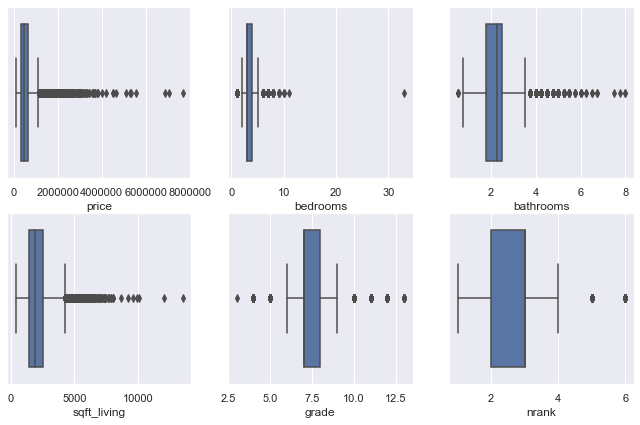

In [21]:
plt.figure(figsize=(10,10))
plt.subplot(331)
sns.boxplot(df['price'])
plt.subplot(332)
sns.boxplot(df['bedrooms'])
plt.subplot(333)
sns.boxplot(df['bathrooms'])
plt.subplot(334)
sns.boxplot(df['sqft_living'])
plt.subplot(335)
sns.boxplot(df['grade'])
plt.subplot(336)
sns.boxplot(df['nrank'])

In [22]:
print("Number of rows before:" , len(df))
df = df[df.price < 2000000]
df = df[df.bedrooms < 6]
df = df[df.bathrooms < 5]
df = df[df.sqft_living < 10000]


print("Number of rows after:" ,len(df))

Number of rows before: 21597
Number of rows after: 21052


Initially seems to be some problems with view, waterfront and yr_revovated(wrong number of rows)
sqft_basement should also be converted to a number value and yr_renovated should be a category. Let's check how many null values there are

it looks like a good reason yr_renovated could have null values is because the house was never renovated - let's just replace the nulls with 0

The date needs to be swithed to a datetime object so it's easier to manipuate - luckily the database is in a format pandas can easily convert 

sqft_basement is coming up as an object which means there are some strings in there.  When taking a closer inspection, there are a lot of values that show up as ? - which means the house probably dosnt have a basement - let's replace those with 0s

In [23]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2307
view               61
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3750
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
nrank               0
climrank            0
dtype: int64

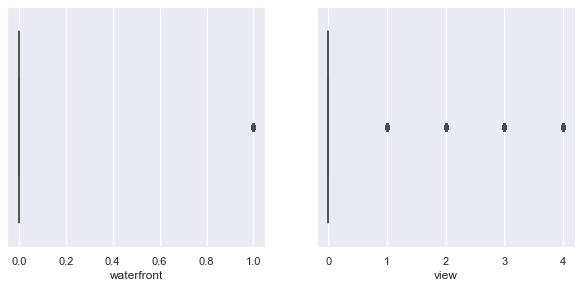

In [24]:
plt.figure(figsize=(14,14))
plt.subplot(331)
sns.boxplot(df['waterfront'])
plt.subplot(332)
sns.boxplot(df['view'])

In [25]:
df.date = pd.to_datetime(df.date)
df.index = df.date
df.waterfront = df.waterfront.fillna(0)
df.view = df.view.fillna(0)
df.yr_renovated = df.yr_renovated.fillna(0)
df.sqft_basement = df.sqft_basement.fillna(0)

In [26]:
df.floors  =df.floors.astype(int)
df.bathrooms  =df.bathrooms.astype(int)
df.sqft_basement = df.sqft_basement.map(lambda x: '0' if x == '?' else x)
df.sqft_basement = df.sqft_basement.astype('float')

In [27]:
def cross_validation(X,y,cv=15,show_scores=False):
    score = cross_val_score(linreg,X, y,cv=cv,scoring='r2')
    return round(sum(score)/len(score)*100)

def feature_selection(X,y):
    est=sm.OLS(y,X).fit()
    pvalues = pd.DataFrame(est.pvalues,columns=['p'])
    features = list(pvalues[pvalues.p<.05].index)
    return features

In [28]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'nrank', 'climrank'],
      dtype='object')

Let's drop some columns we arent going to use in our model

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21052 entries, 2014-10-13 to 2014-10-15
Data columns (total 23 columns):
id               21052 non-null int64
date             21052 non-null datetime64[ns]
price            21052 non-null float64
bedrooms         21052 non-null int64
bathrooms        21052 non-null int64
sqft_living      21052 non-null int64
sqft_lot         21052 non-null int64
floors           21052 non-null int64
waterfront       21052 non-null float64
view             21052 non-null float64
condition        21052 non-null int64
grade            21052 non-null int64
sqft_above       21052 non-null int64
sqft_basement    21052 non-null float64
yr_built         21052 non-null int64
yr_renovated     21052 non-null float64
zipcode          21052 non-null int64
lat              21052 non-null float64
long             21052 non-null float64
sqft_living15    21052 non-null int64
sqft_lot15       21052 non-null int64
nrank            21052 non-null int64
climrank       

In [30]:

df.waterfront = df.waterfront.astype('category')

df.zipcode = df.zipcode.astype('category')
df.id = df.id.astype('category')

df.waterfront = pd.get_dummies(df.waterfront, prefix='waterfront',drop_first=True)

df.zipcode = pd.get_dummies(df.zipcode, prefix='zipcode',drop_first=True)
df.id=pd.get_dummies(df.id, prefix='id',drop_first=True)



In [31]:
df =df.drop(['date', 'long','condition','yr_renovated','sqft_basement'], axis=1)

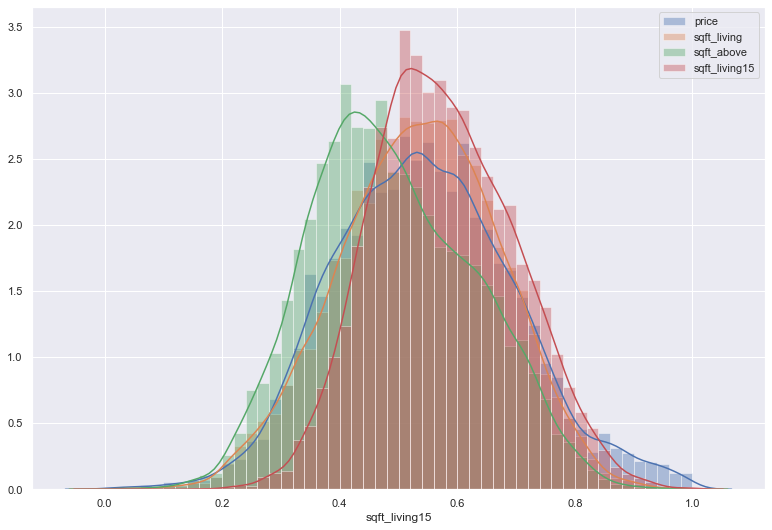

In [32]:
df['price'] = np.log(df.price)
df['sqft_living'] = np.log(df.sqft_living)
df['sqft_living15'] = np.log(df.sqft_living15)
df['sqft_above'] = np.log(df.sqft_above)
df.price = (df['price']-min(df['price']))/(max(df['price'])-min(df['price']))
df.sqft_living = (df['sqft_living']-min(df['sqft_living']))/(max(df['sqft_living'])-min(df['sqft_living']))
df.sqft_above = (df['sqft_above']-min(df['sqft_above']))/(max(df['sqft_above'])-min(df['sqft_above']))
df.sqft_living15 = (df['sqft_living15']-min(df['sqft_living15']))/(max(df['sqft_living15'])-min(df['sqft_living15']))
sns.distplot(df.price,label="price")
sns.distplot(df.sqft_living,label="sqft_living")
sns.distplot(df.sqft_above,label="sqft_above")
sns.distplot(df.sqft_living15,label="sqft_living15")
plt.legend()
plt.show()

In [33]:
# create a Python list of feature names
feature_cols = ['id','bathrooms','sqft_living','sqft_lot','waterfront', 'view',
       'grade', 'sqft_above', 'yr_built', 
                'lat', 'sqft_living15', 'nrank','climrank']


# using feature selection colums
X = df[feature_cols]
# choosing y as predictor
y = df.price
feature_cols = feature_selection(X,y)
X=df[feature_cols]



# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

# compute the RMSE of our predictions
print("Root mean squared error: ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Model Accuracy: ',cross_validation(X,y),' %')

Root mean squared error:  0.0596614911174293
Model Accuracy:  84.0  %


In [43]:
df.drop('price',axis=1)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,yr_built,zipcode,lat,sqft_living15,sqft_lot15,nrank,climrank
date,,,,,,,,,,,,,,,,,
2014-10-13,0,3,1,0.383390,5650,1,0,0.0,7,0.386791,1955,0,47.5112,0.452896,5650,2,599813.662265
2014-12-09,0,3,2,0.640707,7242,2,0,0.0,7,0.589968,1951,0,47.7210,0.539649,7639,2,504434.142897
2015-02-25,0,2,1,0.242275,10000,1,0,0.0,6,0.244424,1933,0,47.7379,0.717562,8062,2,504434.142897
2014-12-09,0,4,3,0.551134,5000,1,0,0.0,7,0.347863,1965,0,47.5208,0.458435,5000,3,599813.662265
2015-02-18,0,3,2,0.500176,8080,1,0,0.0,8,0.504613,1987,0,47.6168,0.563223,7503,3,741523.911689
2014-05-12,0,4,4,0.887379,101930,1,0,0.0,11,0.784631,2001,0,47.6561,0.926770,101930,3,741523.911689
2014-06-27,0,3,2,0.506992,6819,2,0,0.0,7,0.511489,1995,0,47.3097,0.644645,6819,2,313779.863575
2015-01-15,0,3,1,0.347938,9711,1,0,0.0,7,0.351024,1963,0,47.4095,0.530695,9711,2,367195.163324
2015-04-15,0,3,1,0.519290,7470,1,0,0.0,7,0.347863,1960,0,47.5123,0.559046,8113,2,599813.662265


In [44]:
# create a Python list of feature names



# using feature selection colums
X = df.drop('price',axis=1)
# choosing y as predictor
y = df.price
feature_cols = feature_selection(X,y)
X=df[feature_cols]



# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)

# fit the model to the training data (learn the coefficients)
ridge.fit(X_train, y_train)

# make predictions on the testing set
y_pred = ridge.predict(X_test)

# compute the RMSE of our predictions
print("Root mean squared error: ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Model Accuracy: ',cross_validation(X,y),' %')

Root mean squared error:  0.05956374441764181
Model Accuracy:  84.0  %


In [ ]:
df[['price','nrank','sqft_living']].corr()


## Conclusion

* The size of the house and the neighborhood it's in are the two biggest factors that influence price.
* If you want to flip a home - it's a good idea to look at the average home value of the zipcode.  Buy low sell high is still applicable in house selling.
* Ridge Regression performs only slightly better than linear regression in this model